<font size = +3><b><u> Phase 3 Project </u></b></font>

# Business Case

## Stakeholder

**CDC / HHS / Local Public Health Office**

<u>Business Goals:</u>

1. Make sure that adequate supply of vaccines for demand
2. Try to vaccinate as many people as possible

## Business Questions

<b><font size = +1.5> 1. Can we build a model that will accurately predict who will get the seasonal flu vaccine?</font></b>

**Why is it useful to have this model that will predict *individuals* getting the flu shot?**

1. This model can help the CDC accurately coordinate nationwide vaccination production and distribution


2. Can help with dissemination of public health campaigns
 * Targeted advertising: making sure that reminders/messaging gets to people who would get the vaccine

**Goals:**
* 1. Target = Accuracy (true positives)
  * Identifying people who will get the  seasonal flu vaccine 
  
  <br>   
  
* 2. Minimize False Negatives (people who we predict will NOT get the vaccine, but actually do)
  * Lower FN = higher recall rate 
  
  <br>  
  
* 3. Tradeoff = greater False Positives (people who we predict will get vaccine, but actually do not)

---

Reasoning:

* Better to overpredict vaccines than underpredict (surplus better situation than shortage)
* Data showing burden of not getting vaccinated worse than cost of surplus (need to find)
* Worst case situation: shortage of available vaccines, people want vaccine but cannot get it.

### TO-DO: need to brainstorm inferential questions

---

# Import Packages + Create Dataset

In [1]:
# Import needed packages

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


%matplotlib inline

In [2]:
# Import Training Data (Training_Set Features and Training_Set Labels)


training_set_features = pd.read_csv('data/training_set_features.csv')
training_set_labels = pd.read_csv('data/training_set_labels.csv')

In [3]:
# Merge training_set_features with training_set_labels to create a full training_set_df

df = pd.merge(training_set_features, training_set_labels,  how='inner', on='respondent_id')

In [4]:
# Copy of df, in case:

df2 = df.copy()

In [5]:
# Examine full dataset & available variables. 
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

**First glance observations:**

1. *Outcome Variable:* Seasonal_Vaccine (whether or not an individual got the seasonal flu vaccine)


2. Significant amount of missing data for: <br>
health_insurance, <br>
employment_industry & employment_occupation (not actually missing, NaN = not employed)


3. Irrelevant variables: Respondent ID + all variables solely related to H1N1 vaccine (only focusing on the flu vaccine). 



<b>Variables to be removed from dataset:</b> 
* respondent_id, h1n1_vaccine, h1n1_concern, h1n1_knowledge, doctor_recc_h1n1, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc

In [7]:
# Remove irrelevant variables from dataset

df.drop(['respondent_id', 'h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc'], axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

# Data Cleaning + Exploratory Data Analysis

## Missing Data

First, let's look at variables with >10% missing data. Worth keeping or dropping?


In [9]:
gap_cols = []

for col in df.columns:
    if df[col].isna().sum() > 0.1* len(df.index):
        gap_cols.append(col)

print("Columns with >10% missing data:")
gap_cols


Columns with >10% missing data:


['health_insurance',
 'income_poverty',
 'employment_industry',
 'employment_occupation']

1. Health Insurance
2. Employment_Industry
3. Employment_Occupation
4. Income_Poverty

In [10]:
# Health Insurance
print(df.health_insurance.value_counts())

#Income Poverty: 
df.income_poverty.value_counts()


1.0    12697
0.0     1736
Name: health_insurance, dtype: int64


<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

* Health Insurance: Given imbalanced binary data and more than 50% missing, best to drop from dataset.
* Income Poverty: may be reasonable to impute, keep for now.

Employment_Industry and Employment_Occupation
* Not actually missing: only relevant if employment status = "Employed".
* Given large missing data, the labels are confidential, and we already have employment status: drop both columns.


In [11]:
# Dropping health_insurance, employment_industry and employment_occupation

df.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  opinion_seas_vacc_effective  26245 non-null  float64
 12  opinion_seas_risk            26193 non-null  float64
 13  opinion_seas_sic

## Feature Engineering

1. Behavioral Composite
    * Combine all 7 behavioral variables into a variable representing "Flu Behavioral Conscientiousness"

2. Opinion Composite
    * Combine all 3 opinion variables into a variable representing "Pro-Vaccine Attitude"

In [13]:
df['behavioral_comp'] = df[list(df.columns)[:7]].sum(axis=1)

df['opinion_comp'] = df['opinion_seas_vacc_effective'] + df['opinion_seas_risk'] + (6 - df['opinion_seas_sick_from_vacc'])

In [14]:
df['opinion_comp'].value_counts()

10.0    5784
11.0    5317
12.0    2973
14.0    2311
13.0    2283
8.0     2219
9.0     1861
7.0     1437
15.0     922
6.0      455
5.0      257
4.0      167
3.0      114
Name: opinion_comp, dtype: int64

In [15]:
# Remove individual variables from dataset

drop_col = list(df.columns)[:7] + list(df.columns)[11:14]
drop_col

df.drop(drop_col, axis=1, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   doctor_recc_seasonal   24547 non-null  float64
 1   chronic_med_condition  25736 non-null  float64
 2   child_under_6_months   25887 non-null  float64
 3   health_worker          25903 non-null  float64
 4   age_group              26707 non-null  object 
 5   education              25300 non-null  object 
 6   race                   26707 non-null  object 
 7   sex                    26707 non-null  object 
 8   income_poverty         22284 non-null  object 
 9   marital_status         25299 non-null  object 
 10  rent_or_own            24665 non-null  object 
 11  employment_status      25244 non-null  object 
 12  hhs_geo_region         26707 non-null  object 
 13  census_msa             26707 non-null  object 
 14  household_adults       26458 non-null  float64
 15  ho

## Variable Types

    * Numeric Continuous: household_adults, household_children, ?behavioral_comp, opinion_comp
* Numeric Categorical: doctor_recc_seasonal, chronic_med_condition, child_under_6_months, health_worker
* Object Categorical: all the object variables

## Exploratory Analyses

### Comparing Percentage of People who were Vaccinated vs. Not

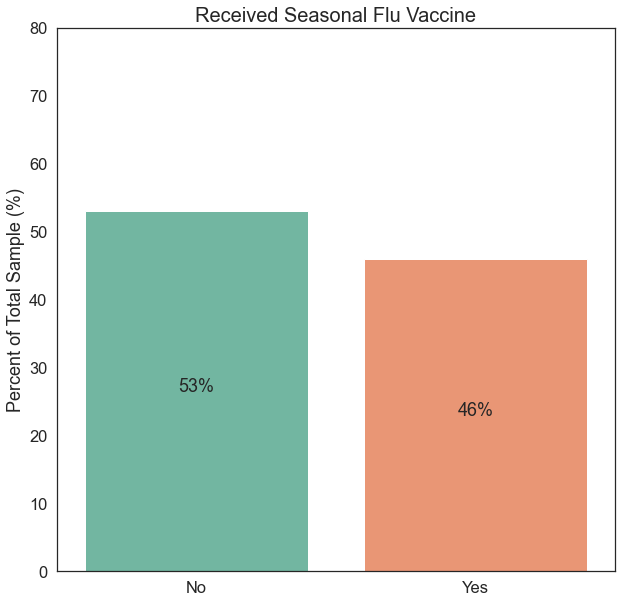

In [17]:
percent = list((df['seasonal_vaccine'].value_counts(normalize=True).values*100).astype(int))

sns.set_theme(context='notebook', palette="Set2", 
              style='white', font='sans-serif', font_scale = 1.5, 
              color_codes=True, rc={'figure.figsize':(10,10)})

vax = sns.barplot(x = ['No', 'Yes'], y = percent)
vax.set_ylabel("Percent of Total Sample (%)")
vax.set_ylim(0, 80)
vax.set_title('Received Seasonal Flu Vaccine', fontsize=20);

for loc, label in enumerate(percent):
    vax.text(loc, label/2, (str(int(round(label, ndigits=0))) + '%'), ha='center');

### Relationships between individual variables and seasonal_vaccine

Remove:
* Rent to Own
* Census MSA
* Household --> make one

No handles with labels found to put in legend.


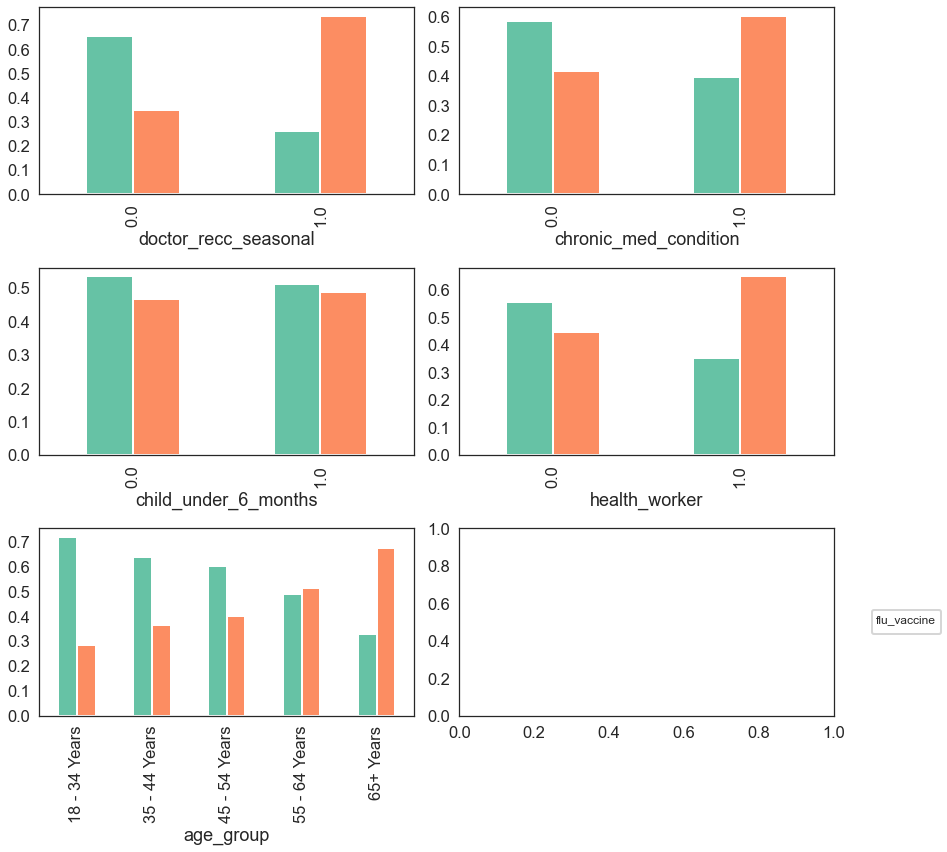

In [18]:
fig, ax = plt.subplots(3,2, figsize=(12,12))

sns.set_theme(context='poster', palette="Set2", 
              style='white', font='sans-serif', font_scale = 0.5, 
              color_codes=True)


for i, col in enumerate(df.columns[0:5]):
    x = i//2
    y = i%2
    pd.crosstab(df[col], df['seasonal_vaccine'], normalize='index').plot(kind='bar', ax=ax[x][y], legend=False)

plt.tight_layout()
plt.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='flu_vaccine'
)
    


<Figure size 720x720 with 0 Axes>

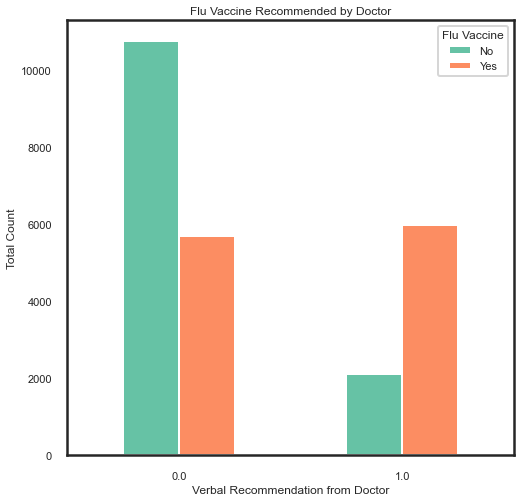

In [46]:
plt.figure()
plt.rcParams.update({'font.size': 40})

ax = pd.crosstab(df['doctor_recc_seasonal'], df['seasonal_vaccine']).plot.bar(rot=0, legend=True, figsize=(8,8));
ax.set_title('Flu Vaccine Recommended by Doctor')
ax.set_xlabel('Verbal Recommendation from Doctor')
ax.set_ylabel('Total Count')
ax.legend(["No", "Yes"], title='Flu Vaccine')


In [20]:
df['household'] = df['household_adults'] + df['household_children']

In [21]:
df.columns

Index(['doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months',
       'health_worker', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'seasonal_vaccine', 'behavioral_comp',
       'opinion_comp', 'household'],
      dtype='object')

In [22]:
list(df['income_poverty'].value_counts().index)

in_di = {'<= $75,000, Above Poverty': 2, '> $75,000': 3, 'Below Poverty': 1}

In [23]:
df['income_poverty'].replace(in_di, inplace = True)

df.drop(['household_adults', 'household_children'], axis=1, inplace=True)

In [24]:
len(df.columns)

18

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   doctor_recc_seasonal   24547 non-null  float64
 1   chronic_med_condition  25736 non-null  float64
 2   child_under_6_months   25887 non-null  float64
 3   health_worker          25903 non-null  float64
 4   age_group              26707 non-null  object 
 5   education              25300 non-null  object 
 6   race                   26707 non-null  object 
 7   sex                    26707 non-null  object 
 8   income_poverty         22284 non-null  float64
 9   marital_status         25299 non-null  object 
 10  rent_or_own            24665 non-null  object 
 11  employment_status      25244 non-null  object 
 12  hhs_geo_region         26707 non-null  object 
 13  census_msa             26707 non-null  object 
 14  seasonal_vaccine       26707 non-null  int64  
 15  be

# Data Preparation + Pipelines

In [26]:
# Separate X, y

X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

In [27]:
# Train-test split before pipelines

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Data Preprocessing Pipelines by Variable Type

In [28]:
# Num Pipe
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler()),
])

In [29]:
# Cat Pipeline

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [30]:
# Column Transformer

CT = ColumnTransformer(transformers=[
    ('num_tr', num_pipe, selector(dtype_include=np.number)),
    ('cat_tr', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

## ModelWithCV Function:

In [31]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [32]:
X_train.describe()

,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,income_poverty,behavioral_comp,opinion_comp,household
count,18395.000000,19313.000000,19425.000000,19433.000000,16761.000000,20030.000000,19574.000000,19842.000000
mean,0.333243,0.284575,0.081905,0.113827,2.184953,3.023814,10.634413,1.422185
std,0.471385,0.451224,0.274227,0.317609,0.623555,1.610410,2.290280,1.300176
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,11.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,3.000000,4.000000,12.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,15.000000,6.000000


# Preliminary Models

## Dummy Model

In [33]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [34]:
dummy_model_pipe = ModelWithCV(dummy_model, model_name = 'dummy', X=X_train, y=y_train)

CV Results for `dummy` model:
            0.53110 ± 0.00020 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

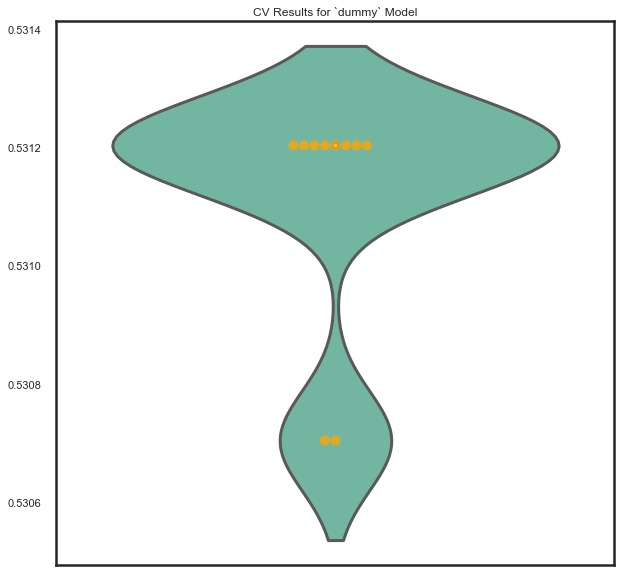

In [35]:
dummy_model_pipe.print_cv_summary()

fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

## First Simple Model

In [36]:
logreg = Pipeline([
    ('ct',CT),
    ('logreg', LogisticRegression(random_state=42))
])

logreg.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f92509efaf0>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

In [37]:
fsm_model_pipe = ModelWithCV(logreg, model_name = 'fsm', X=X_train, y=y_train)

In [38]:
y_pred = logreg.predict(X_test)

In [39]:
cf_matrix = confusion_matrix(y_test, y_pred)


In [40]:
cf_matrix

array([[2926,  708],
       [ 821, 2222]])

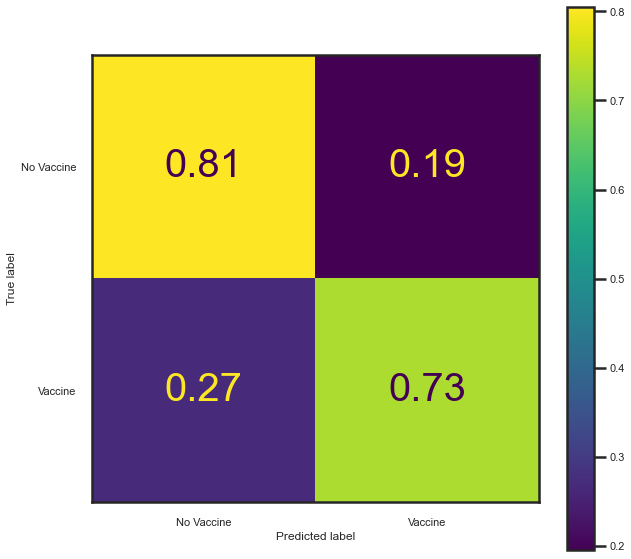

In [41]:
plot_confusion_matrix(logreg, X_test, y_test, display_labels = ['No Vaccine', 'Vaccine'], normalize='true');

CV Results for `fsm` model:
            0.76281 ± 0.01406 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

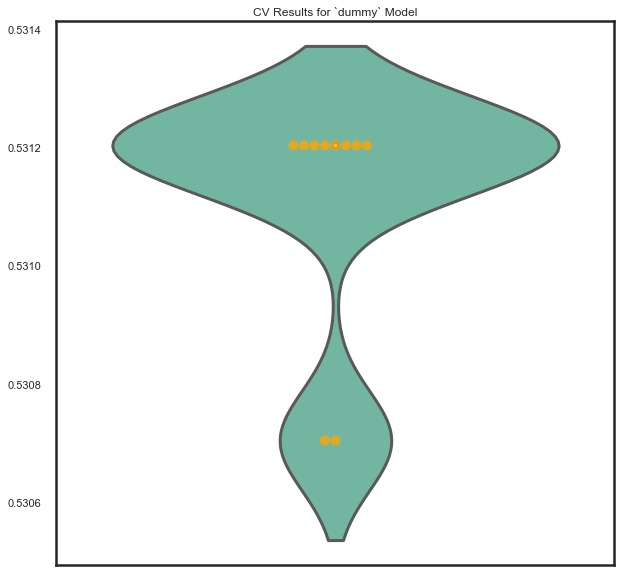

In [42]:
fsm_model_pipe.print_cv_summary()

fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

## Random Forest Model

,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,seasonal_vaccine,behavioral_comp,opinion_comp,household
0,0.0,0.0,0.0,0.0,55 - 64 Years,< 12 Years,White,Female,1.0,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,2.0,7.0,0.0
1,0.0,0.0,0.0,0.0,35 - 44 Years,12 Years,White,Male,1.0,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",1,4.0,8.0,0.0
2,NaN,1.0,0.0,0.0,18 - 34 Years,College Graduate,White,Male,2.0,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",0,1.0,9.0,2.0
3,1.0,1.0,0.0,0.0,65+ Years,12 Years,White,Female,1.0,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",1,3.0,14.0,0.0
4,0.0,0.0,0.0,0.0,45 - 54 Years,Some College,White,Female,2.0,Married,Own,Employed,qufhixun,"MSA, Not Principle City",0,4.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.0,0.0,0.0,0.0,65+ Years,Some College,White,Female,2.0,Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0,2.0,11.0,0.0
26703,1.0,0.0,0.0,1.0,18 - 34 Years,College Graduate,White,Male,2.0,Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",0,2.0,11.0,1.0
26704,0.0,0.0,0.0,0.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",1,5.0,13.0,0.0
26705,0.0,0.0,0.0,0.0,18 - 34 Years,Some College,Hispanic,Female,2.0,Married,Rent,Employed,lrircsnp,Non-MSA,0,0.0,7.0,1.0


In [43]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([
    ('ct', CT),
    ('rfc', rfc)
])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                         model_name="forest_pipe",
                         X=X_train,
                          y=y_train)

#forest_pipe.fit(X_train, y_train)




NameError: name 'forest_pip' is not defined

In [44]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.75397 ± 0.01279 accuracy
        


In [ ]:
forest_pipe.score(X_test_sc)